# Reproduction of grokking on modular addition problem

## Step 1: Produce dataset
I start by producing a simple algorithmic dataset, similar to the one in the core paper. The network will be trained to evaluate an expression of the type (a + b) mod p, where a and b are numbered inputs and p is a prime number.

In [3]:
# Imports
import os
import datetime
import random
import einops
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from notebook import notebookapp

import torch 
import torch.nn as nn
import torch.nn.functional as F

seed = 0
local_host = True if 'oveggeland' in list(notebookapp.list_running_servers())[0]['notebook_dir'] else False

In [4]:
# Dataset params
p = 97
frac_train = 0.3

# Create a randomly shuffled list of all possible combinations of input numbers: (i+j) % p = ?
pairs = [(i, j, p) for i in range(p) for j in range(p)]
random.seed(seed)
random.shuffle(pairs)

# Divide list into train and validation sets
div = int(frac_train*len(pairs))
train_set, val_set = pairs[:div], pairs[div:]

## Step 2: Define model (2L decoder only transformer)
Using NEEL NANDAS (INTERPRETABILITY) as inspiration

In [5]:
# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient 
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []
    
    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name
    
    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output, 
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")
    
    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")
    
    def forward(self, x):
        return x

In [6]:
# Define network architecture
# I defined my own transformer from scratch so I'd fully understand each component 
# - I expect this wasn't necessary or particularly important, and a bunch of this 
# replicates existing PyTorch functionality

# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
    
    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']
        
    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache
    
    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')
    
    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

## Step 3: Training the model

In [12]:
lr=1e-3
weight_decay = 0.5
d_model = 128
num_epochs = 10000
save_models = True
save_every = 100
save_root = Path("checkpoints") # Path("PhD/IMT4392/project/modulo/checkpoints") if not local_host else Path("checkpoints")
stopping_thresh = -1
seed = 0
fn_name = 'add' #['add', 'subtract', 'x2xyy2','rand']

# Model parameters
num_layers = 1
batch_style = 'full'
d_vocab = p+1
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0, "Error with parameters"
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
use_ln = False
random_answers = np.random.randint(low=0, high=p, size=(p, p))
fns_dict = {'add': lambda x,y:(x+y)%p, 'subtract': lambda x,y:(x-y)%p, 'x2xyy2':lambda x,y:(x**2+x*y+y**2)%p, 'rand':lambda x,y:random_answers[x][y]}
fn = fns_dict[fn_name]

In [8]:
# Helper function for model training

def full_loss(model, data, device):
    # Take the final position only
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to(device)
    return cross_entropy_high_precision(logits, labels)

def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly 
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes 
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    
    return loss

In [9]:
def run_exp(run_name=f"{fn_name}__"+datetime.datetime.now().strftime("%Y_%m_%d__%H_%M_%S")):
    # Init model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln)
    model.to(device)

    # Define optimizing process
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.98))
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(step/10, 1))

    # Run formalities
    if save_models:
        os.mkdir(save_root/run_name)
        save_dict = {'model':model.state_dict(), 'train_data':train_set, 'val_data':val_set}
        torch.save(save_dict, save_root/run_name/'init.pth')

    # Allocate lists for loss storage
    train_losses = []
    val_losses = []

    # Train over several epochs
    for epoch in range(num_epochs):
        # Calculate train and val loss
        train_loss = full_loss(model, train_set, device)
        train_losses.append(train_loss.item())

        val_loss = full_loss(model, val_set, device)
        val_losses.append(val_loss.item())

        # Print status
        if epoch%100 == 0: print(f"{epoch}_{np.log(train_loss.item()):.4f}_{np.log(val_loss.item()):.4f}")

        # Calc gradients and perform backprop
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        scheduler.step()

        if val_loss.item() < stopping_thresh:
            break

        if (save_models) and (epoch%save_every == 0):
            if val_loss.item() < stopping_thresh:
                break
            save_dict = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'epoch': epoch,
            }
            torch.save(save_dict, save_root/run_name/f"{epoch}.pth")
            print(f"Saved model to {save_root/run_name/f'{epoch}.pth'}")

    if not save_models:
        os.mkdir(save_root/run_name)
    save_dict = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'epoch': epoch,
    }

    torch.save(save_dict, save_root/run_name/f"final.pth")
    print(f"Saved model to {save_root/run_name/f'final.pth'}")

# Step 4: Analysis

## The effect of training size ratio

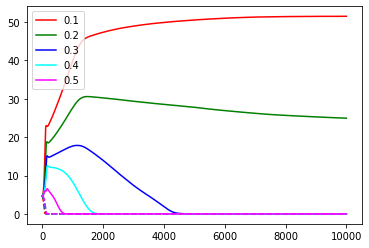

In [22]:
# Show how the amount of training data effects fraccing
colors = ['r', 'g', 'b', 'cyan', 'magenta']
for i, frac_train in enumerate([0.1, 0.2, 0.3, 0.4, 0.5]):
    load_dict = torch.load(f"checkpoints/frac_{frac_train}/final.pth")
    
    plt.plot(load_dict['train_losses'], linestyle='dashed', c=colors[i])
    plt.plot(load_dict['val_losses'], c=colors[i], label=f"{frac_train}")
plt.legend()
plt.show()

## The effect of weigth decay 

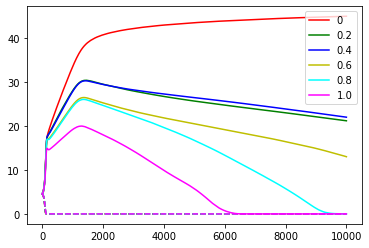

In [26]:
# Show how the amount of training data effects fraccing
colors = ['r', 'g', 'b', 'y', 'cyan', 'magenta']
for i, frac_train in enumerate([0, 0.2, 0.4, 0.6, 0.8, 1.0]):
    load_dict = torch.load(f"checkpoints/wd_{frac_train}/final.pth")
    
    plt.plot(load_dict['train_losses'], linestyle='dashed', c=colors[i])
    plt.plot(load_dict['val_losses'], c=colors[i], label=f"{frac_train}")
plt.legend()
plt.show()